Notebook correspondant à la section 3.2 du rapport, pour la résolution des équations couplées de la précession de Larmor :
\begin{equation}
\left\{
    \begin{aligned}
        \frac{dM_x}{dt} &= \omega M_y \\
        \frac{dM_y}{dt} &= -\omega M_x
    \end{aligned}
\right.
\end{equation}

In [362]:
#imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Physical parameters

In [363]:
M_z0 = tf.constant(0, dtype='float32')
W = 2*np.pi
lamb = 0.3

t_a = -1
t_b = 1

t_0 = 0

Defining the ODE : this function returns the value expected of the derivative, given the independant variable and the value of the function.

In [364]:
def ODE(T, Mz, lamb, W) :
    return lamb*W*(Mz**2-1)
    #return -tf.cos(W*T)

Training parameters

In [365]:
N = 5 #number of samples for the independant variable
training_points = np.linspace(t_a,t_b,N)
training_points = tf.convert_to_tensor(training_points, dtype=tf.float32)
#training_points = tf.constant(training_points, dtype=tf.float32)

load_model = False
load_filename = "models/2_NN_direct_training_N=10"
save_model = False
save_filename = "models/2_NN_direct_training_N=100"
learning_rate = 5e-3
epochs = 10000
display_step = 500#min(max(1,epochs//100), 1000)

Initializing the network

In [366]:
# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 4 # 1st layer number of neurons
#n_hidden_2 = 8  # 2nd layer number of neurons
n_output = 1    # output layer number of neurons

tf.random.set_seed(24514)

#model definition :
model = tf.keras.Sequential([
  tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.sigmoid, input_shape=(n_input,)),  # input shape required
  #tf.keras.layers.Dense(n_hidden_2, activation=tf.nn.sigmoid),
  tf.keras.layers.Dense(n_output)
])

if load_model :
    model = tf.keras.models.load_model(load_filename)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

Loss function
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape


In [367]:
def loss_function(model, input_tensor, M_z0, lamb, W, print_variables = False):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_tensor)
        output = model(input_tensor, training=False)
        Mz = M_z0+input_tensor*output[:,0]

    dMz = tape.gradient(Mz, input_tensor)

    e = dMz - ODE(input_tensor, Mz, lamb, W)
    
    if print_variables:
        print("Mz", Mz.numpy())
        print("dMz", dMz.numpy())
        print("ODE", ODE(input_tensor, Mz, lamb, W).numpy())
        print("e", e.numpy())
        print("e**2", (e**2).numpy())
        print("error", tf.reduce_mean(e**2).numpy())

        w_list = [w.numpy() for w in model.layers[0].weights[0][0]]
        print("\nw :",w_list)
        print("\nw :",model.layers[0].weights[0])
        print("b :",model.layers[0].bias.numpy())
        v_list = [v.numpy() for v in tf.reshape(model.layers[1].weights[0], (n_hidden_1))]
        print("v :",v_list)
        print("v :",model.layers[1].weights[0])
        print("b2 :",model.layers[1].bias.numpy())
    


    return tf.reduce_mean(e**2)

Gradient of loss

In [368]:
def grad(model, input_tensor, M_z0, lamb, W):
    with tf.GradientTape() as tape2: #watch_accessed_variables=True, persistent = True
        #tape2.watch(input_tensor)
        loss_value = loss_function(model, input_tensor, M_z0, lamb, W, print_variables = False)
        

    gradient = tape2.gradient(loss_value, model.trainable_variables)
    #jacobian = tape2.jacobian(loss_value, model.trainable_variables)
    #batch_jacobian = tape2.batch_jacobian(loss_value, model.trainable_variables)
    """
    print("Grad w",gradient[0].numpy())
    print("Grad b",gradient[1].numpy())
    print("Grad v",gradient[2].numpy())
    print("Grad b2",gradient[3].numpy())

    print("jacobian w",jacobian[0].numpy())
    print("jacobian b",jacobian[1].numpy())
    print("jacobian v",jacobian[2].numpy())
    print("jacobian b2",jacobian[3].numpy())
    """
    #print("batch_jacobian", batch_jacobian)


    

    return loss_value, gradient

In [369]:
def numerical_grad_w(model, input_tensor, M_z0, lamb, W, eps = 1e-4) :
    loss_value = loss_function(model, input_tensor, M_z0, lamb, W)
    grad_w = []
    original_weights = model.layers[0].weights[0] + 0
    print("\noriginal_weights", original_weights)
    for i in range(n_hidden_1) :
        eps_vect = tf.constant([[0]*i+[eps]+[0]*(n_hidden_1-i-1)], dtype=tf.float32)
        print("Loss found for eps_vect",eps_vect.numpy(), ":")
        model.layers[0].weights[0].assign(original_weights+eps_vect)
        loss_eps = loss_function(model, input_tensor, M_z0, lamb, W)
        grad_w.append(((loss_eps-loss_value)/eps).numpy())
        print("Loss:", loss_eps.numpy(), ", grad_w[",i,"] :", ((loss_eps-loss_value)/eps).numpy())
        model.layers[0].weights[0].assign(original_weights)
    print("weights probably not modified", model.layers[0].weights[0])
    return grad_w

Training the neural network

In [375]:

losses = []
epochs_displayed = []

for epoch in range(epochs) :
    loss_value, grads = grad(model, training_points, M_z0, lamb, W)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % display_step == 0 :
        print("Loss after",epoch,"/",epochs,"epochs :",loss_value.numpy())
        losses.append(loss_value.numpy())
        epochs_displayed.append(epoch)

loss_value, grads = grad(model, training_points, M_z0, lamb, W)
#print("num grad_w",numerical_grad_w(model, training_points, M_z0, lamb, W))
print("Final loss after",epochs,"epochs :",loss_value.numpy())
losses.append(loss_value.numpy())
epochs_displayed.append(epochs)

Loss after 0 / 10000 epochs : 0.077738956
Loss after 500 / 10000 epochs : 0.04609579
Loss after 1000 / 10000 epochs : 0.028910408
Loss after 1500 / 10000 epochs : 0.020561676
Loss after 2000 / 10000 epochs : 0.016605351
Loss after 2500 / 10000 epochs : 0.014571233
Loss after 3000 / 10000 epochs : 0.013335003
Loss after 3500 / 10000 epochs : 0.01243464
Loss after 4000 / 10000 epochs : 0.011684612
Loss after 4500 / 10000 epochs : 0.011007472
Loss after 5000 / 10000 epochs : 0.010369198
Loss after 5500 / 10000 epochs : 0.009754847
Loss after 6000 / 10000 epochs : 0.009158345
Loss after 6500 / 10000 epochs : 0.008578359
Loss after 7000 / 10000 epochs : 0.008016045
Loss after 7500 / 10000 epochs : 0.0074723447
Loss after 8000 / 10000 epochs : 0.0069495155
Loss after 8500 / 10000 epochs : 0.0064486316
Loss after 9000 / 10000 epochs : 0.0059710937
Loss after 9500 / 10000 epochs : 0.0055176825
Final loss after 10000 epochs : 0.0050885705


In [371]:
if save_model :
    model.save(save_filename)

Plot the evolution of loss

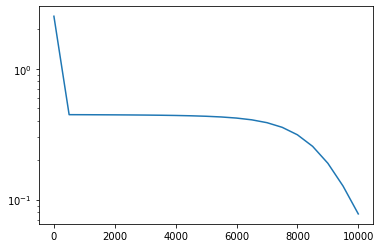

In [372]:
plt.plot(epochs_displayed, losses)
plt.yscale('log')
plt.show()

Compute the analytic solution

In [373]:
def analytic(T, M_z0, lamb, W) :
    K = (M_z0-1) / (M_z0+1)
    Kexp = K*np.exp(2*lamb*W*T)
    Mz_ana = (1+Kexp) / (1-Kexp)
    return Mz_ana

Plot the estimation and the analytic solution

Extreme values of output after : -1.7457788 -0.94860023


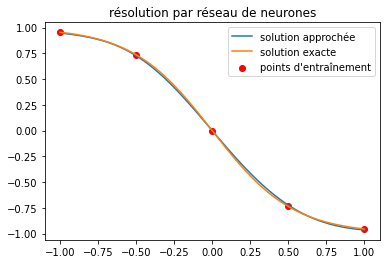

In [376]:
#plot the estimation
nb_plotting_points = 200
plotting_points = np.linspace(t_a,t_b,nb_plotting_points)
plotting_points = tf.convert_to_tensor(plotting_points, dtype=tf.float32)

#neural network estimation
output = model(plotting_points).numpy().reshape((nb_plotting_points))
Mz_NN = M_z0 + (plotting_points-M_z0)*output


print("Extreme values of output after :",min(output), max(output))
#analytic solution
Mz_ana = analytic(plotting_points, M_z0, lamb, W)

#training points
Mz_ana_training = analytic(training_points, M_z0, lamb, W)


plt.plot(plotting_points, Mz_NN, label='solution approchée')
plt.plot(plotting_points, Mz_ana, label='solution exacte')
plt.scatter(training_points, Mz_ana_training, label="points d'entraînement", color='red')

plt.legend()
plt.title('résolution par réseau de neurones')
plt.show()
